## Analysis with GeoPandas
In this notebook, we examine how GeoPandas is used in peforming a spatial analysis. We take an example of looking at the demographic characteristics of where electric vehicle (EV) charging stations have been located in Durham, Wake, and Orange counties with respect to 2010 Census and Social Vulnerability Index values. (It's not a very sensible analysis as done here, but we are concentrating on the mechanics more than the utility of the analysis...)

### Learning Objectives:
* Executing the "data science workflow" with a GeoPandas
 - Read data into a geodataframe (CSV and GeoJSON)
 - Explore the data: columns/column types, summaries, plots
 - Analyze the data...
 - Visualize results
* Subseting features in a geodataframe by attribute
* Merging geodataframes
* Dissolving geodataframe features based on an attribute value
* Joining attributes to a geodataframe
* Spatially joining data from one geodataframe to another
* Generating various plots from single and multiple geodataframes
* Saving a geodataframe to a feature class 

### Workflow:
* **Part 1: Fetching and Exploring Data**
 * 1.1 Import packages
 * 1.2 Read CSV data into geodataframe
 * 1.3 Explore the data in the geodataframe
 * 1.4 Import census data to geodataframe via web service
* **Part 2: Analysis (and Visualization)**
 * 2.1 Subset EV features by attribute
 * 2.2 Merge the three county geodataframes into a single geodataframe
 * 2.3 Dissolve block features to the tract level
 * 2.4 Import and join the social vulnerability data to tract features
 * 2.5 Compute population density for each tract
 * 2.6 Subset EV stations spatially
 * 2.7 Spatially join tract attributes to EV features
* **Part 3: Share Results**
 * 3.1 Share your notebook as html or on GitHub
 * 3.2 Explot your geodataframe(s) as feature classes or CSV files

---
## Part 1: Fetching and Exploring the Data
Here we'll gather and explore the data we'll be using in our analysis. This includes two datasets. First is the list of EV Charging locations, stored as a CSV file in our data folder. This dataset has coordinate columns that we'll use to construct points and convert into a geodataframe.

The second dataset is comprised of 2010 Census BlockGroup data for all of North Carolina. We'll fetch these data from an on line resource using a web service. We'll revisit how web services later; for now, we'll use this process to fetch data for three counties: Durham, Wake, and Orange. 

For each dataset, we'll get the data into geodataframe format and then explore the data in various ways. Then we'll move to Part 2 where we analyse the data. 

### 1.1: Import packages needed in the analysis

In [1]:
#Import packages
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

import matplotlib.pyplot as plt
import contextily as ctx

%matplotlib inline

<H4 style="color:red">♦ Knowledge Check ♦</H4>  

_→ Can you explain what role each package imported might do in our analysis?_

### 1.2: Create a geodataframe from a CSV file
As done in a previous notebook, we want to:
* Import a CSV file containing coordinate columns into a Pandas dataframe,
* Create a collection of Shapely points from the coordinate fields, and 
* Create a geodataframe from the components. 

In [2]:
#Read in charging stations CSV, convert to geodataframe
df = pd.read_csv('./data/NC_Charging_Stations.csv')
geom = [Point(xy) for xy in zip(df['Longitude'],df['Latitude'])]
gdf_stations_all = gpd.GeoDataFrame(df,geometry=geom,crs=4326)

### 1.3: Explore the data in geodataframe
Have a quick look at the contents imported. Things to check include:
* How many rows and columns were imported
* The names, data types, and number of non-null values in each column
* Examine a single record from the geodataframe
* What geometry types are included in the geodataframe?
* Summary statistics of numeric columns, if applicable
* Correlations among column values, if applicable
* Spatial plot of the data

In [3]:
#Examine the data
gdf_stations_all.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 738 entries, 0 to 737
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   index                             738 non-null    int64   
 1   Fuel Type Code                    738 non-null    object  
 2   Station Name                      738 non-null    object  
 3   City                              738 non-null    object  
 4   State                             738 non-null    object  
 5   ZIP                               738 non-null    int64   
 6   Status Code                       738 non-null    object  
 7   Groups With Access Code           738 non-null    object  
 8   Latitude                          738 non-null    float64 
 9   Longitude                         738 non-null    float64 
 10  ID                                738 non-null    int64   
 11  Updated At                        738 non-null    

In [4]:
#Examine a single record of data
gdf_stations_all.iloc[0]

index                                                          312
Fuel Type Code                                                ELEC
Station Name                                           DUKE ENERGY
City                                                     Charlotte
State                                                           NC
ZIP                                                          28202
Status Code                                                      E
Groups With Access Code                                     Public
Latitude                                                   35.2269
Longitude                                                 -80.8502
ID                                                           38892
Updated At                                 2019-11-14 10:14:28 UTC
Country                                                         US
Groups With Access Code (French)                            Public
Access Code                                                 pu

In [5]:
#Reveal the geometry type(s) contained inthe geodataframae
gdf_stations_all.type.unique()

array(['Point'], dtype=object)

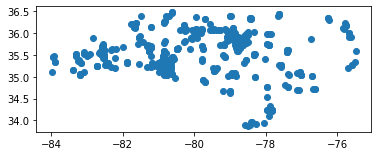

In [6]:
#Plot the data
gdf_stations_all.plot();

<H3 style="color:red">♦ Knowledge Check ♦</H3>

→ _Could you performm the same steps of importing and exploring the USGS gage locations in NC stored in the CSV file `../data/gages.csv`?_
 * Convert data to a geodataframe: `gdf_gages`
 * Explore the data
 * Plot the gage sites

---
### 1.4. Import NC Census Block Group features via NC OneMap's web service
_We will explore web services a bit later, but we'll use the code below to acquire polygon data of census block groups for Durham, Wake, and Orange counties from an NC OneMap Web Service. Once imported, we'll merge these geodataframes together and use them in our subsequet analyses._

* First, to simplify matters, I've created a Python function to fetch data for a specific county given its FIPS code.

In [7]:
#Create a function to read NCOneMap feature services into a geodataframe
def getBlockGroupData(FIPS):
    #Construct the url from the function arguments
    url=f'https://services.nconemap.gov/secure/rest/services/NC1Map_Census/FeatureServer/8/query?' + \
        f"where=GEOID10+LIKE+'{FIPS}%'&outFields=GEOID10,TOTAL_POP&f=geojson"
    
    #Create a geodataframe from the URL
    gdf = gpd.read_file(url)
    
    #Return the geodataframe
    return gdf

* Now, we apply that function for the three counties we want to examine

In [8]:
#Fetch census block groups for Durham, Orange, and Wake counties using the above function
gdf_DurmBlkGroups = getBlockGroupData(37063)
gdf_WakeBlkGroups = getBlockGroupData(37183)
gdf_OrangeBlkGroups = getBlockGroupData(37135)

* _Challenge: See if you can fetch Chatham county block groups (FIPS = 37037)_

In [9]:
#Challenge: See if you can fetch Chatham county block groups (FIPS = 37037)
gdf_ChathamBlkGroups = getBlockGroupData(37037)

* **Explore** the data...
 * What is its coordinate reference system?
 * What columns are included?
 * What does the first record look like?

In [10]:
#Show the Durham block group geodataframe's coordinate reference system
gdf_DurmBlkGroups.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
#Explore the Durham block group geodataframe's columns...
gdf_DurmBlkGroups.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   GEOID10    153 non-null    object  
 1   TOTAL_POP  153 non-null    int64   
 2   geometry   153 non-null    geometry
dtypes: geometry(1), int64(1), object(1)
memory usage: 3.7+ KB


In [12]:
#Examine a sample record from the geodataframe
gdf_DurmBlkGroups.iloc[0]

GEOID10                                           370630020072
TOTAL_POP                                                 2306
geometry     POLYGON ((-78.93115770704857 35.95827210689065...
Name: 0, dtype: object

* **Visualize** the data...

<AxesSubplot:>

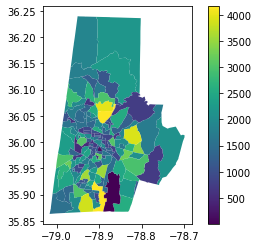

In [14]:
#Plot Durhham's population
gdf_DurmBlkGroups.plot('TOTAL_POP',cmap='viridis', legend = True)

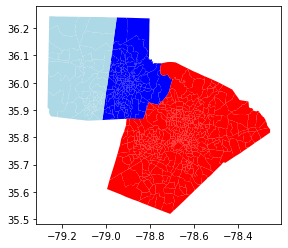

In [15]:
#Plot the block groups for all three counties
thePlot = gdf_DurmBlkGroups.plot(color='blue')
gdf_WakeBlkGroups.plot(ax=thePlot,color='red')
gdf_OrangeBlkGroups.plot(ax=thePlot,color='lightblue');

---
## Part 2: The Analysis (and Visualization)
Now that we've obtained a few datasets and got them into geodataframes, we'll perform some analysis. These include:
* Subsetting the EV charging stations for those in specific cities.
* Identifying the census blocks surrounding each EV station, within a distance of 1km
 * To do this, we'll merge the Durham, Wake, and Orange Co block data selected above
 * Then we'll buffer our selected EV station points a distance of 1km
 * And finally, we'll select blocks that intersect the EV station buffers

### 2.1: Subset the EV Station points based on attribute values
Doc: https://geopandas.org/indexing.html

Subsetting features in a geodataframe uses the same methods as subsetting recordsin a Pandas dataframe. Here we'll run through an example by subsetting EV stations found oly within Durham, Raleigh, and Chapel Hill. 

* **2.1.1** Examine unique values in the `City` column

In [16]:
#Reveal the unique values in the City column
gdf_stations_all['City'].unique()

array(['Charlotte', 'Raleigh', 'Concord', 'Fayetteville', 'High Point',
       'Lumberton', 'Durham', 'Sanford', 'Burlington', 'Asheville',
       'Cary', 'Boone', 'Forest City', 'Gastonia', 'Goldsboro',
       'Greensboro', 'Greenville', 'Hendersonville', 'Hickory',
       'Jacksonville', 'Montreat', 'New Bern', 'Reidsville',
       'Roanoke Rapids', 'Rockingham', 'Mount Airy', 'Salisbury',
       'Southern Pines', 'Statesville', 'Wake Forest', 'Wilkesboro',
       'Wilmington', 'Wilson', 'Winston-Salem', 'Clyde', 'Cornelius',
       'Elizabeth City', 'Asheboro', 'Black Mountain', 'Chapel Hill',
       'Hillsborough', 'Cherokee', 'Flat Rock', 'Clinton',
       'Kings Mountain', 'Knightdale', 'Mt. Holly', 'Mooresville',
       'Weaverville', 'Fletcher', 'Pittsboro', 'Belmont', 'Lowell',
       'Apex', 'Dallas', 'Lincolnton', 'Arden', 'Kernsersville', 'Buxton',
       'Mebane', 'Point Harbor', 'Nags Head', 'Denton', 'Robbinsville',
       'Beaufort', 'Highlands', 'Maiden', 'Huntersville

* **2.2.2** Subset records for those where the City is "Durham", "Raleigh", or "Chapel Hill"

In [17]:
#Subset records where the City is "Durham", "Raleigh", or "Chapel Hill"
gdf_stations = gdf_stations_all.query('City in ("Durham","Raleigh","Chapel Hill")')

* **2.1.3** Explore the results...

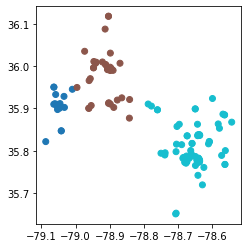

In [18]:
#Plot the results
gdf_stations.plot("City");

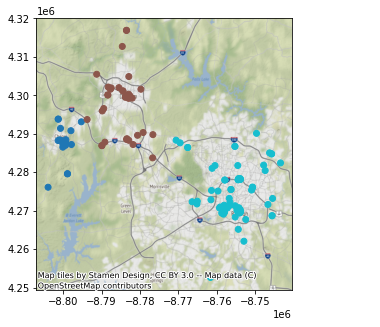

In [19]:
#Plot them with a base map (using Contextily - more later...)
fig, ax = plt.subplots(figsize = (10,5))
gdf_stations.to_crs(3857).plot(ax=ax, column="City")
ctx.add_basemap(ax)

### 2.2: Merge the 3 county block group geodataframes into one
Doc: https://geopandas.org/mergingdata.html
1. Check that all data have the same crs
1. Optionally, add a field to identify the source geodataframe
1. Apply the `append()` function
1. Check/explore the result

We'll start by appending the Wake Co. dataset to the Durham Co. one. Then you will append the Orange Co. dataframe to that product.

* **2.2.1** Check that the two files share the same coordinate reference system

In [20]:
#Check the crs of the two geodataframes
gdf_DurmBlkGroups.crs == gdf_WakeBlkGroups.crs

True

* **2.2.2** Add an identifying column to the source geodataframes

In [21]:
#Add a field to each input, setting values to identify the source dataset
gdf_DurmBlkGroups['County'] = 'Durham'
gdf_WakeBlkGroups['County'] = 'Wake'

* **2.2.3** Append one dataframe to the other

In [22]:
#Append the Wake Co features to the Durham Co features,
gdf_BlkGrp_step1 = gdf_DurmBlkGroups.append(gdf_WakeBlkGroups)

* **2.2.4** Explore the result

In [29]:
#Check to see that the total rows in the merged gdf match the sum of the two component gdfs
len(gdf_DurmBlkGroups)+len(gdf_WakeBlkGroups)==len(gdf_BlkGrp_step1)

True

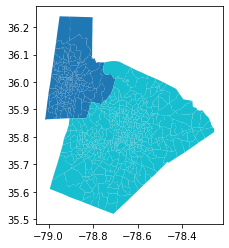

In [30]:
#Plot the result
gdf_BlkGrp_step1.plot('County');

---
<H4 style="color:red">♦ TASK ♦</H4>

_Append the Orange Co blockgroup features to the `gdf_BlkGrp_step` geodataframe we just created._  

**Remember to:**
* check that the coordinate refernce systems are the same, and 
* add a new column to the `gdf_OrangeBlkGroups`, setting its value to the County name.
 
→ Save the result as `gdf_BlkGrps`

In [31]:
#Check that the coordinate refernce systems are the same
gdf_BlkGrp_step1.crs == gdf_OrangeBlkGroups.crs

True

In [32]:
#Add the county field
gdf_OrangeBlkGroups['County'] = 'Orange'

In [33]:
#Append the geodataframes
gdf_BlkGrp = gdf_BlkGrp_step1.append(gdf_OrangeBlkGroups)

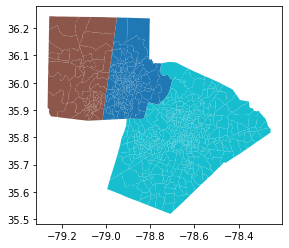

In [34]:
#Plot the output
gdf_BlkGrp.plot('County');

---
### 2.3: Dissolve block features to the tract level
We have Social Vulnerability Data to examine in our analysis, but these data are at the Tract, not BlockGroup level. Thus, to join these attributes to our geodataframe, we'll need to aggregate our blockgroups to the tract level. Fortunately, the `GEOID10` attribute is structured such that the census tract is just the first 11 characters. So we will create a new column holding these first 11 characters, and then we'll dissolve our blockgroup features sharing the same tract ID to single features.

Doc: https://geopandas.org/aggregation_with_dissolve.html
* First, create a new column listing tract IDs (the first 11 digits of the GEOID10)
* Dissolve the features on this attribute, computing aggregate sum of the TOTAL_POP field

* **2.3.1** Create the Tract column from the GEOID10 values

In [35]:
#Create the Tract column
gdf_BlkGrp['TRACT']=gdf_BlkGrp['GEOID10'].str[:11]
gdf_BlkGrp.head()

,GEOID10,TOTAL_POP,geometry,County,TRACT
0,370630020072,2306,"POLYGON ((-78.93116 35.95827, -78.93134 35.958...",Durham,37063002007
1,370630003013,757,"POLYGON ((-78.91474 36.00974, -78.91414 36.009...",Durham,37063000301
2,370630021003,1899,"POLYGON ((-78.91871 36.23867, -78.91966 36.238...",Durham,37063002100
3,370630015022,1024,"POLYGON ((-78.94415 36.01224, -78.94501 36.012...",Durham,37063001502
4,370630019002,2118,"POLYGON ((-78.75128 35.93160, -78.75109 35.931...",Durham,37063001900


* **2.3.2** Dissolve features on the Tract column

In [36]:
#Dissolve features on tract, computing summed population
gdf_Tract = gdf_BlkGrp.dissolve('TRACT',aggfunc={'TOTAL_POP':'sum','County':'first'})
gdf_Tract.head()

,geometry,TOTAL_POP,County
TRACT,,,
37063000101,"POLYGON ((-78.87389 36.02467, -78.87411 36.023...",3152,Durham
37063000102,"POLYGON ((-78.89258 36.02165, -78.89264 36.019...",4535,Durham
37063000200,"POLYGON ((-78.88314 36.00375, -78.88339 36.003...",2946,Durham
37063000301,"POLYGON ((-78.91091 36.01322, -78.91097 36.012...",2504,Durham
37063000302,"POLYGON ((-78.89597 36.01018, -78.89598 36.008...",3426,Durham


In [37]:
gdf_Tract.shape

(275, 3)

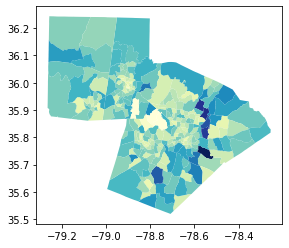

In [38]:
#Plot the data
gdf_Tract.plot('TOTAL_POP',cmap='YlGnBu');

### 2.4: Import the Social Vulnerability Data and join with the Tract features
Now that we have the data at the tract level, we can join the Social Vulnerability Index data, stored in a CSV file (`./data/NC_SVI_2018.csv`).

Doc: https://geopandas.org/mergingdata.html#attribute-joins
* Import the SVI data as a Pandas dataframe
* Append records from the SVI dataframe to the Tracts geodataframe

* **2.4.1** Import and explore the SVI data into a Pandas dataframe

In [41]:
#Import and explore the SVI data
df_SVI = pd.read_csv('./data/NC_SVI_2018.csv',dtype={'FIPS':'str','ST':'str','STCNTY':'str',})
df_SVI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2192 entries, 0 to 2191
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ST      2192 non-null   object 
 1   STATE   2192 non-null   object 
 2   STCNTY  2192 non-null   object 
 3   COUNTY  2192 non-null   object 
 4   FIPS    2192 non-null   object 
 5   SVI     2192 non-null   float64
dtypes: float64(1), object(5)
memory usage: 102.9+ KB


>**Challenge**:<br>→ _Modify the `read_csv()` command above so that 'ST' and 'STCNTY' are also imported as strings._

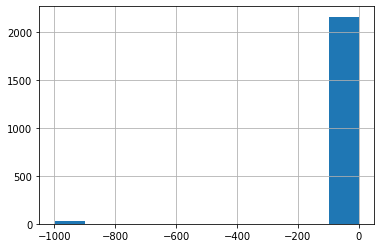

In [42]:
#Plot a histogram of the SVI values
df_SVI['SVI'].hist();

<h3><font color='red'> Whoops!!! </h3>
Values should be between 0 and 1, but we see in the histogram that a few value are down near -1000. Turns out a few records have SVI values of -999. We need to remove those records.

In [43]:
#Create a mask of values greater than or equal to zero
valid_mask = df_SVI['SVI'] >= 0
#Apply that mask
df_SVI_fixed = df_SVI.loc[valid_mask]

In [44]:
df_SVI.shape, df_SVI_fixed.shape

((2192, 6), (2162, 6))

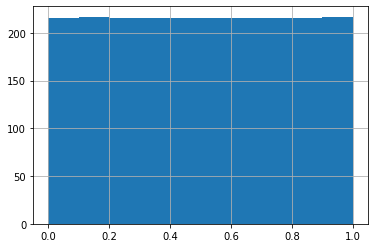

In [45]:
#View the histogram again
df_SVI_fixed['SVI'].hist();

_Phew! Exploring the data payed off!_

* **2.4.2** Append the dataframe to the tracts

In [46]:
#Have a look at the merge command syntax
gdf_Tract.merge?

In [47]:
#Join the SVI data to the tract features
gdf_Tract_joined = gdf_Tract.merge(df_SVI_fixed,
                                   left_on='TRACT', #"Join to" field in the traft features 
                                   right_on='FIPS', #"Join on" field in the SVI dataframe
                                   how='left')      #Keep all tract features, even if they are missing SVI
#Examine the output
gdf_Tract_joined.head()

,geometry,TOTAL_POP,County,ST,STATE,STCNTY,COUNTY,FIPS,SVI
0,"POLYGON ((-78.87389 36.02467, -78.87411 36.023...",3152,Durham,37,NORTH CAROLINA,37063,Durham,37063000101,0.8080
1,"POLYGON ((-78.89258 36.02165, -78.89264 36.019...",4535,Durham,37,NORTH CAROLINA,37063,Durham,37063000102,0.8547
2,"POLYGON ((-78.88314 36.00375, -78.88339 36.003...",2946,Durham,37,NORTH CAROLINA,37063,Durham,37063000200,0.5706
3,"POLYGON ((-78.91091 36.01322, -78.91097 36.012...",2504,Durham,37,NORTH CAROLINA,37063,Durham,37063000301,0.7048
4,"POLYGON ((-78.89597 36.01018, -78.89598 36.008...",3426,Durham,37,NORTH CAROLINA,37063,Durham,37063000302,0.3392


In [48]:
#Explore the output
gdf_Tract_joined.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 275 entries, 0 to 274
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   geometry   275 non-null    geometry
 1   TOTAL_POP  275 non-null    int64   
 2   County     275 non-null    object  
 3   ST         270 non-null    object  
 4   STATE      270 non-null    object  
 5   STCNTY     270 non-null    object  
 6   COUNTY     270 non-null    object  
 7   FIPS       270 non-null    object  
 8   SVI        270 non-null    float64 
dtypes: float64(1), geometry(1), int64(1), object(6)
memory usage: 21.5+ KB


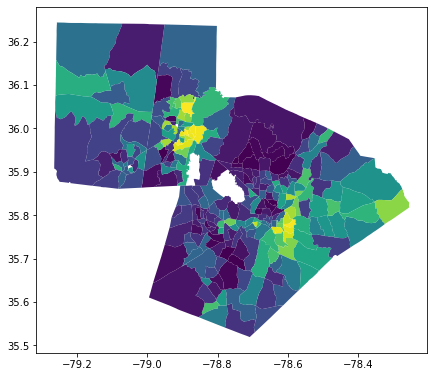

In [49]:
#Plot the output
gdf_Tract_joined.plot('SVI',figsize=(7,7));

_Looks like we have some features missing SVI data. Let's examine those more closely._

In [50]:
#Create a mask of null SVI values
gdf_Tract_joined['SVI'].isnull()

0      False
1      False
2      False
3      False
4      False
       ...  
270    False
271    False
272    False
273     True
274     True
Name: SVI, Length: 275, dtype: bool

In [51]:
#Apply the mask
gdf_Tract_joined.loc[gdf_Tract_joined['SVI'].isnull()]

,geometry,TOTAL_POP,County,ST,STATE,STCNTY,COUNTY,FIPS,SVI
20,"POLYGON ((-78.91595 36.00978, -78.91718 36.009...",1941,Durham,NaN,NaN,NaN,NaN,NaN,NaN
59,"POLYGON ((-78.88307 35.88604, -78.88532 35.886...",4,Durham,NaN,NaN,NaN,NaN,NaN,NaN
79,"POLYGON ((-79.04653 35.91343, -79.04624 35.913...",2350,Orange,NaN,NaN,NaN,NaN,NaN,NaN
273,"POLYGON ((-78.80909 35.88187, -78.80944 35.881...",2,Wake,NaN,NaN,NaN,NaN,NaN,NaN
274,"POLYGON ((-78.74827 35.87112, -78.74843 35.871...",30,Wake,NaN,NaN,NaN,NaN,NaN,NaN


_We can either assign a value to these missing values or leave them as no data. We'll just leave them blank for now..._

### 2.5: Compute Population Density for Each Tract
Our combined dataframes have a field indicating the total population in each block group. We want to compute population density from this and from the area of each tract. We don't yet have an area field in our dataframe, but we can compute that from our spatial features. But before we can do this, we need to transform our data into a projected coordinate system. So... the steps for this analysis include:
* Transform the dataframe to a projected coordinate system (UTM Zone 17N)
* Compute a new `Area_km2` column in our dataframe
* Compute a new `PopDens` column in our dataframe by dividing `TOTAL_POP` by `Area_km` 

* **2.5.1** Transform the dataframe to a projected coordinate system (UTM Zone 17N)

In [52]:
#Project the data to UTM Zone 17N (EPSG 32617)
gdf_Tract_utm = gdf_Tract_joined.to_crs(32617)

* **2.5.2** Compute a new `Area_km2` column in our dataframe

In [53]:
#Compute a new column of geometry area (in sq km)
gdf_Tract_utm['Area_km2'] = gdf_Tract_utm['geometry'].area / 1000000

* **2.5.3** Compute a new `PopDens` column in our dataframe by dividing `TOTAL_POP` by `Area_km` 

In [54]:
#Compute a new column of population density
gdf_Tract_utm['PopDens'] = gdf_Tract_utm['TOTAL_POP'] / gdf_Tract_utm['Area_km2']

* **2.5.4** Explore the results

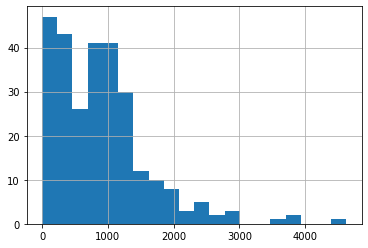

In [55]:
#Plot the distribution of areas
gdf_Tract_utm['PopDens'].hist(bins=20);

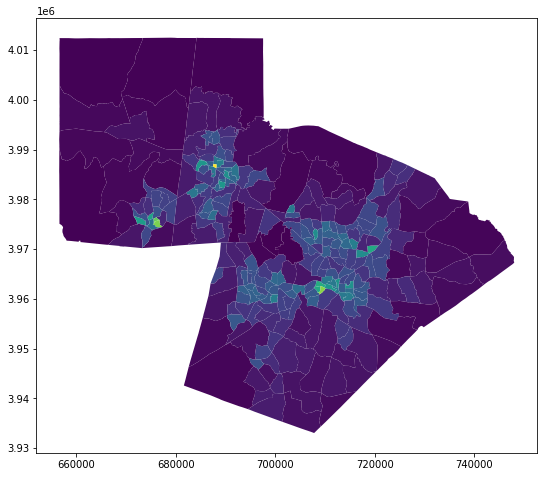

In [56]:
#Plot a map of log tranformed population density
gdf_Tract_utm.plot('PopDens',figsize=(10,8),cmap='viridis');

* _**2.5.5** Log transform the data to improve the visualization_

In [57]:
#Log transform the pop_dens data
import numpy as np
gdf_Tract_utm['PD_log'] = np.log(gdf_Tract_utm['PopDens'])

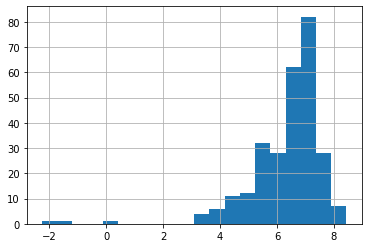

In [58]:
#Plot the log-transformed distribution of areas
gdf_Tract_utm['PD_log'].hist(bins=20);

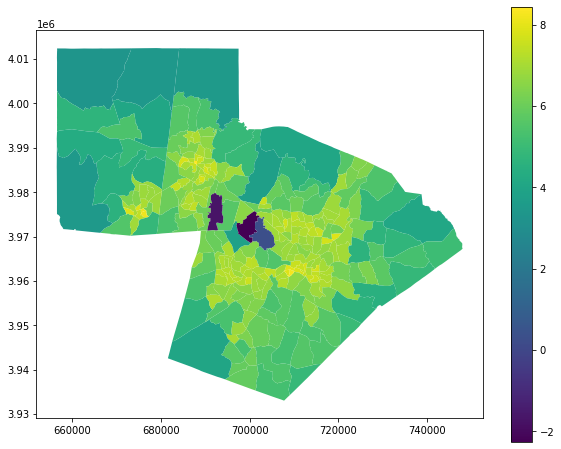

In [60]:
#Plot a map of log tranformed population density
gdf_Tract_utm.plot('PD_log',figsize=(10,8),cmap='viridis', legend=True);

### 2.6: Subset EV stations spatially
Doc: https://geopandas.org/set_operations.html  
Previously, we subset EV stations by an attribute (City). Here we'll see how we can instead select features spatially. We do this with GeoPanda's Overlay operations.

**To spatially select features**:
* Ensure both datasets share the same coordinate reference system; transform if needed
* Use the `overlay`:`intersection` operation to select EV features overlap with the Tracts dataset
* Examine the outputs

* **2.6.1** Ensure both datasets share the same crs; transform if not

In [62]:
#Ensure both datasets share the same crs
print(gdf_stations_all.crs, gdf_Tract_utm.crs)

epsg:4326 epsg:32617


In [63]:
#Project one dataset to match the other
gdf_stations_all_utm = gdf_stations_all.to_crs(gdf_Tract_utm.crs)
print(gdf_stations_all_utm.crs)

epsg:32617


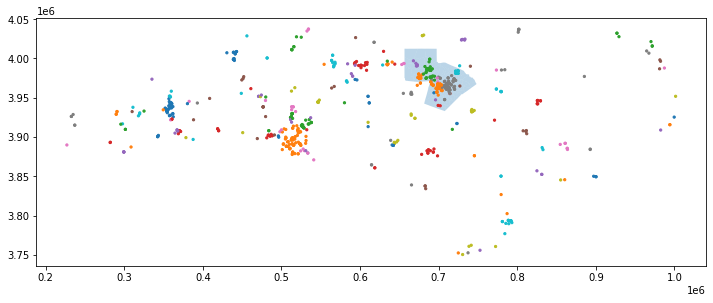

In [64]:
#plot points on tracts
ax = gdf_Tract_utm.plot(figsize=(12,6),alpha=0.3)
gdf_stations_all_utm.plot(column='City',ax=ax,markersize=5);

* **2.6.2** Select EV stations that intersect the county features

In [65]:
#Intersect the two dataframes
gdf_stations_select = gpd.overlay(
    df1=gdf_stations_all_utm,
    df2=gdf_Tract_utm,
    how='intersection'
)

* **2.6.3** Examine the results

In [66]:
#View the data
gdf_stations_select.head()

,index,Fuel Type Code,Station Name,City,State,ZIP,Status Code,Groups With Access Code,Latitude,Longitude,...,ST,STATE,STCNTY,COUNTY,FIPS,SVI,Area_km2,PopDens,PD_log,geometry
0,332,ELEC,City of Raleigh - Municipal Building,Raleigh,NC,27601,E,Public,35.778416,-78.643470,...,37,NORTH CAROLINA,37183,Wake,37183050100,0.3077,2.145192,1315.96601,7.182326,POINT (713000.165 3961933.778)
1,333,ELEC,City of Raleigh - Downtown,Raleigh,NC,27601,E,Public,35.774350,-78.642287,...,37,NORTH CAROLINA,37183,Wake,37183050100,0.3077,2.145192,1315.96601,7.182326,POINT (713117.970 3961485.268)
2,625,ELEC,Green Square Public Parking Garage - Level B1,Raleigh,NC,27603,E,Public,35.781360,-78.641200,...,37,NORTH CAROLINA,37183,Wake,37183050100,0.3077,2.145192,1315.96601,7.182326,POINT (713197.515 3962265.327)
3,626,ELEC,Green Square Public Parking Garage - Level P1,Raleigh,NC,27603,E,Private,35.781360,-78.641200,...,37,NORTH CAROLINA,37183,Wake,37183050100,0.3077,2.145192,1315.96601,7.182326,POINT (713197.515 3962265.327)
4,682,ELEC,City of Raleigh - City Center Deck,Raleigh,NC,27601,E,Public,35.774619,-78.637705,...,37,NORTH CAROLINA,37183,Wake,37183050100,0.3077,2.145192,1315.96601,7.182326,POINT (713531.501 3961525.091)


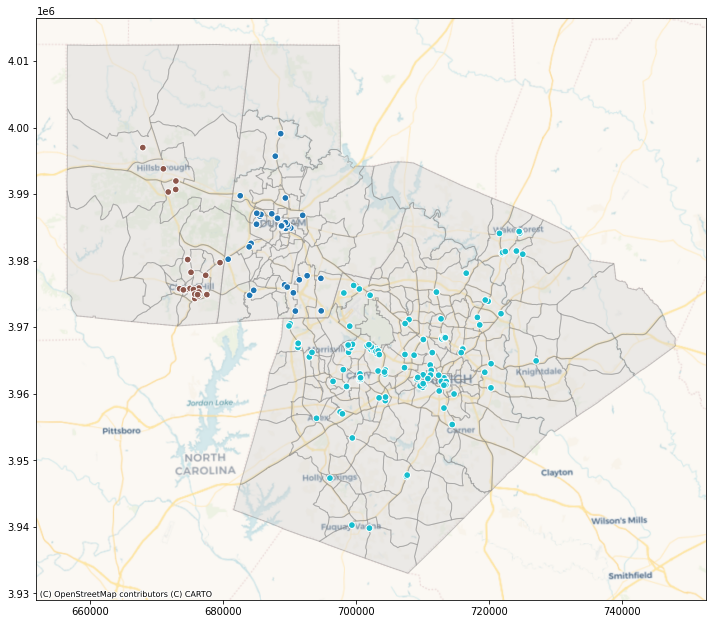

In [68]:
#Plot the data
ax = gdf_Tract_utm.plot(color='lightgrey',
                        edgecolor='grey',
                        alpha=0.4,
                        figsize=(12,12))
gdf_stations_select.plot(ax=ax,
                         column='County',
                         markersize=45,
                         edgecolor='white');
ctx.add_basemap(ax, crs=gdf_Tract_utm.crs,
                source=ctx.providers.CartoDB.Voyager)

### 2.7: Spatially join tract attributes to EV features
Doc: https://geopandas.org/mergingdata.html#spatial-joins

Now that we have a proper susbset of EV stations, let's add demographic data to our EV locations by peforming a spatial join with the tract geodataframe.

* **2.7.1** Ensure the datasets involved share the same coordinate reference system  
_→ What would happen if we made a typo and only included a single equals sign??_

In [69]:
#Compare crs
gdf_stations_select.crs == gdf_Tract_utm.crs

True

* **2.7.2** Execute the spatial join

In [70]:
#Execute the spatial join
gdf_JoinedData = gpd.sjoin(
    left_df = gdf_stations_select,  # "Left" geodataframe
    right_df = gdf_Tract_utm,       # "Right" geodataframe
    how='left',                     # Choose "left" so we don't lose any EV stations 
    op='intersects',                # Select the overlay operation
    lsuffix='ev',                   # Add the "ev" suffix to EV fields
    rsuffix='tracts'                # Add the "tracts" suffix to Tract fields
)

* **2.7.3** Explore the result

In [71]:
#View the data
gdf_JoinedData.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 214 entries, 0 to 213
Data columns (total 39 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   index                             214 non-null    int64   
 1   Fuel Type Code                    214 non-null    object  
 2   Station Name                      214 non-null    object  
 3   City                              214 non-null    object  
 4   State                             214 non-null    object  
 5   ZIP                               214 non-null    int64   
 6   Status Code                       214 non-null    object  
 7   Groups With Access Code           214 non-null    object  
 8   Latitude                          214 non-null    float64 
 9   Longitude                         214 non-null    float64 
 10  ID                                214 non-null    int64   
 11  Updated At                        214 non-null    

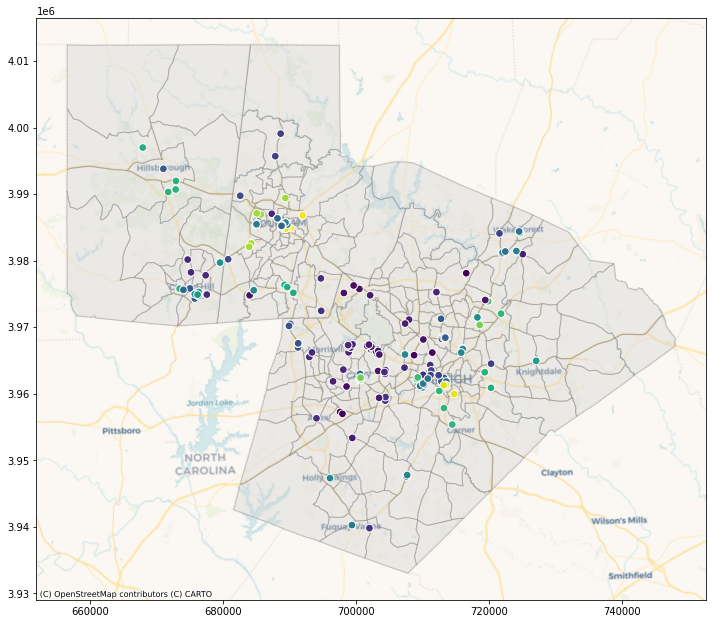

In [72]:
#Plot
ax = gdf_Tract_utm.plot(color='lightgrey',edgecolor='grey',alpha=0.4,figsize=(12,12))
gdf_JoinedData.plot(ax=ax,column='SVI_ev',markersize=60,edgecolor='white');
ctx.add_basemap(ax, crs=gdf_Tract_utm.crs,source=ctx.providers.CartoDB.Voyager)

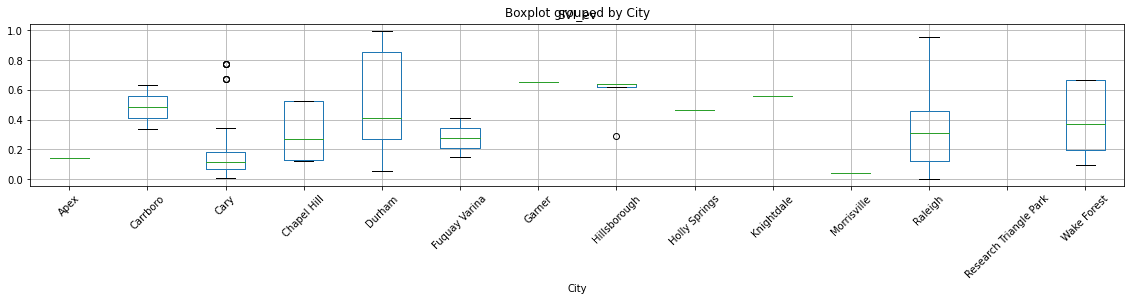

In [73]:
#Make some graphical plots
ax=pd.DataFrame(gdf_JoinedData).boxplot(
    column='SVI_ev',
    by='City',
    rot=45,
    figsize=(19,3));

## Part 3. Share results
With this document we now have a fully reproducible analytic workflow, complete with visualizations of our result. We can export this notebook as an HTML document and share that, or if we commit this document to our GitHub account and share the link to that notebook. 

### 3.1: Sharing your notebook

* **3.1.1**
 * Export your completed notebook as an HTML document. 
 * View it in a web browser
 
* **3.1.2**
 * Commit the changes to your forked repository
 * Navigate to https://nbviewer.jupyter.org/ and paste your repository's URL
 * Share this link with others...

We can also save the resulting geodataframes as feature classes for more analysis, either in Python or in ArcGIS Pro. 

### 3.2: Exporting the geodataframe
We can export our `gdf_JoinedData` geodataframe easily,either as a shapefile or a CSV file. 

* **3.2.1** Export the final geodataframe to a feature class

In [74]:
#Export the geodataframe to a shapefile
gdf_JoinedData.to_file(
    filename='./data/EV_sites_with_data.shp',
    driver='ESRI Shapefile',
    index=False
)

* **3.2.2** Export the final geodataframe to a csv file

In [75]:
#Export the geodataframe to a CSV file
pd.DataFrame(gdf_JoinedData).to_csv(
    './data/foo.csv',
    index=False
)